# EfficientNetV2S - RandAugment only

Things we've done:
- Data cleaning (No Shrek nor Rick)
- Data augmentation in learning phase using RandAugment
- Class weights
- Batch normalization
- Dropout
- L2 regularization (L2)
- Adam optimizer
- Early stopping
- Learning Grade Decay

In [ ]:
# To clean the img folder
# %rm img/*

In [3]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [4]:
# Install python 3.11
!mamba create -n py311 -y
!source /opt/conda/bin/activate py311 && mamba install python=3.11 jupyter mamba -y

!sudo rm /opt/conda/bin/python3
!sudo ln -sf /opt/conda/envs/py311/bin/python3 /opt/conda/bin/python3
!sudo rm /opt/conda/bin/python3.7
!sudo ln -sf /opt/conda/envs/py311/bin/python3 /opt/conda/bin/python3.7
!sudo rm /opt/conda/bin/python
!sudo ln -sf /opt/conda/envs/py311/bin/python3 /opt/conda/bin/python


Looking for: []

Preparing transaction: done
Verifying transaction: done
Executing transaction: done

To activate this environment, use

     $ mamba activate py311

To deactivate an active environment, use

     $ mamba deactivate


Looking for: ['python=3.11', 'jupyter', 'mamba']

warning  libmamba Cache file "/opt/conda/pkgs/cache/c6f2354e.json" was modified by another program
[+] 0.0s
[+] 0.1s
rapidsai/linux-64 (check zst) ╸━━━━━━━━━━━━━━   0.0 B @  ??.?MB/s Checking  0.1s[+] 0.2s
rapidsai/linux-64 (check zst) ╸━━━━━━━━━━━━━━   0.0 B @  ??.?MB/s Checking  0.2srapidsai/linux-64 (check zst)                       Checked  0.2s
warning  libmamba Cache file "/opt/conda/pkgs/cache/86b0f08d.json" was modified by another program
[+] 0.0s
[+] 0.1s
rapidsai/noarch (check zst) ━━━━━━━━━━━━╸━━━━   0.0 B @  ??.?MB/s Checking  0.1s[+] 0.2s
rapidsai/noarch (check zst) ━━━━━━━━━━━━╸━━━━   0.0 B @  ??.?MB/s Checking  0.2s[+] 0.3s
rapidsai/noarch (check zst) ━━━━━━━━━━━━╸━━━━   0.0 B @  ??.?MB/s Ch

In [5]:
!python --version

Python 3.11.10


In [6]:
%%writefile requirements.txt
tensorflow==2.17.0
keras==3.4.1

Writing requirements.txt


In [7]:
!pip install keras_cv

In [8]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 102.3 MB/s eta 0:00:0000:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.9.1 requires tensorflow~=2.16.1, but you have tens

In [9]:
!pip install keras-cv

In [10]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os
import re

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
if IN_COLAB:
    import tensorflow as tf
    from tensorflow import keras as tfk
    from tensorflow.keras import layers as tfkl
else:
    import tensorflow as tf
    import keras as tfk
    from keras.layers import Input, Dense, Dropout, Lambda
    from keras import layers as tfkl

import keras_cv

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.2)
sns.set_style('white')
plt.rc('font', size=11)
%matplotlib inline

2.17.0


In [11]:
print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")

Tensorflow version -> 2.17.0
Keras version -> 3.4.1


In [ ]:
# Global counter for plot numbering
plot_counter = 0

# Create img directory if it doesn't exist
if not os.path.exists('img'):
    os.makedirs('img')

# Original show function
original_show = plt.show

def save_and_show():
    def custom_show(*args, **kwargs):
        global plot_counter
        plot_counter += 1

        # Get current figure and its title
        current_fig = plt.gcf()
        title = current_fig._suptitle
        if title:
            # Clean title for filename
            title_text = re.sub(r'[^\w\s-]', '', title.get_text()).strip()
            title_text = re.sub(r'[-\s]+', '_', title_text)
            filename = f'img/{plot_counter:03d}_{title_text}.pdf'
        else:
            filename = f'img/{plot_counter:03d}.pdf'

        # Save figure
        current_fig.savefig(filename, format='pdf', bbox_inches='tight')
        print(f"Saved plot to {filename}")

        # Call original show function
        return original_show(*args, **kwargs)

    # Replace plt.show with custom function
    plt.show = custom_show

# Initialize the callback
save_and_show()

# Load Data

In [12]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/gdrive')
    %cd /gdrive/My Drive/Università/Magistrale Polimi/AN2DL/Labs/Homework 1
    # %cd /gdrive/My Drive/Homework 1

In [13]:
# Load the .npz File
if IN_COLAB:
    data = np.load('training_set.npz')
else:
    data = np.load('/kaggle/input/blood-cells/training_set.npz')

# Extract Images and Labels
images = data['images']
labels = data['labels']

# Verify the shape of the images and labels
print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

Images shape: (13759, 96, 96, 3)
Labels shape: (13759, 1)


In [15]:
# Define input and output dimensions
input_shape = (96, 96, 3)
output_shape = 8

In [16]:
label_dict = {
  0: "Basophil",
  1: "Eosinophil",
  2: "Erythroblast",
  3: "Immature granulocytes",
  4: "Lymphocyte",
  5: "Monocyte",
  6: "Neutrophil",
  7: "Platelet"
}

# Data Cleaning

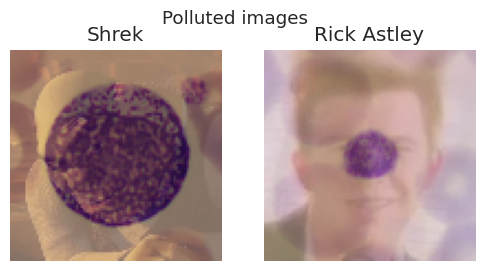

In [17]:
# IDs of the images to be plotted
image_id_shrek = 12080
image_id_rick = 13628

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Plot the first image (Shrek)
axes[0].imshow(images[image_id_shrek])
axes[0].set_title('Shrek')
axes[0].axis('off')

# Plot the second image (Rick)
axes[1].imshow(images[image_id_rick])
axes[1].set_title('Rick Astley')
axes[1].axis('off')

# Set the main title for the plot
plt.suptitle('Polluted images')
plt.show()

In [18]:
def clean_images(image_to_compare, dataset):

    # Find all images identical to the image with the given ID
    similar_images = []
    for i, image in enumerate(dataset['images']):
        if np.array_equal(image, image_to_compare):
            similar_images.append(i)

    # Create a mask to filter out the similar images
    mask = np.array([i not in similar_images for i in range(len(dataset['images']))])

    # Filter the images and labels
    clean_images = dataset['images'][mask]
    clean_labels = dataset['labels'][mask]

    # print the number of images removed
    print(f"Removed {len(similar_images)} images identical to image")

    return {'images': clean_images, 'labels': clean_labels}

In [19]:
im_shrek = images[image_id_shrek]
im_rick = images[image_id_rick]

data = clean_images(im_shrek, data)
data = clean_images(im_rick, data)

Removed 1600 images identical to image
Removed 200 images identical to image


In [20]:
# Extract Images and Labels
images = data['images']
labels = data['labels']

# Verify the shape of the images and labels
print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

Images shape: (11959, 96, 96, 3)
Labels shape: (11959, 1)


# Data exploration

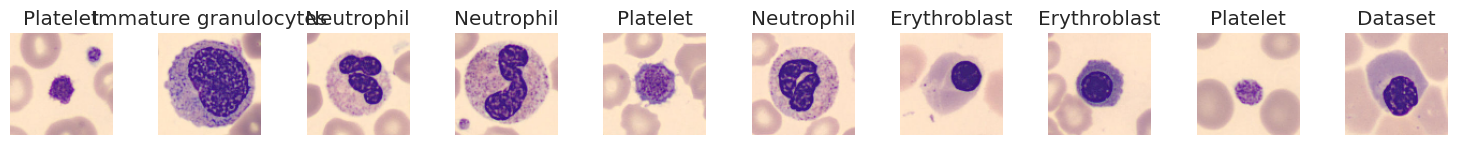

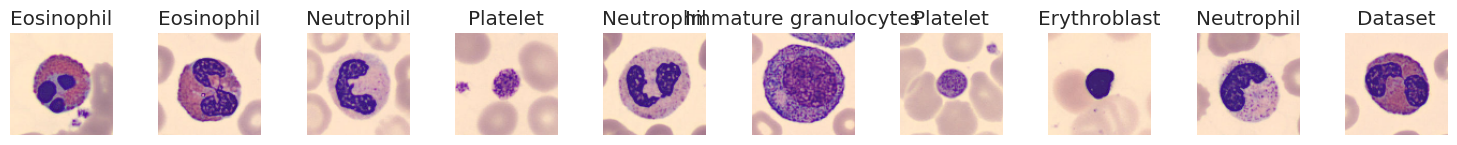

In [21]:
# Determine the number of images
num_images = images.shape[0]

# Calculate the number of rows and columns for the plot
num_cols = 10
num_rows = 2

# Plot each row of images
for row in range(num_rows):
    fig, axes = plt.subplots(1, num_cols, figsize=(15, 1.5))
    for col in range(num_cols):
        idx = row * num_cols + col
        if idx < num_images:
            axes[col].imshow(images[idx], cmap='gray')
            axes[col].set_title(label_dict[labels[idx][0]])
            axes[col].axis('off')
        else:
            axes[col].axis('off')
    plt.tight_layout()
    plt.title("Dataset")

    plt.show()

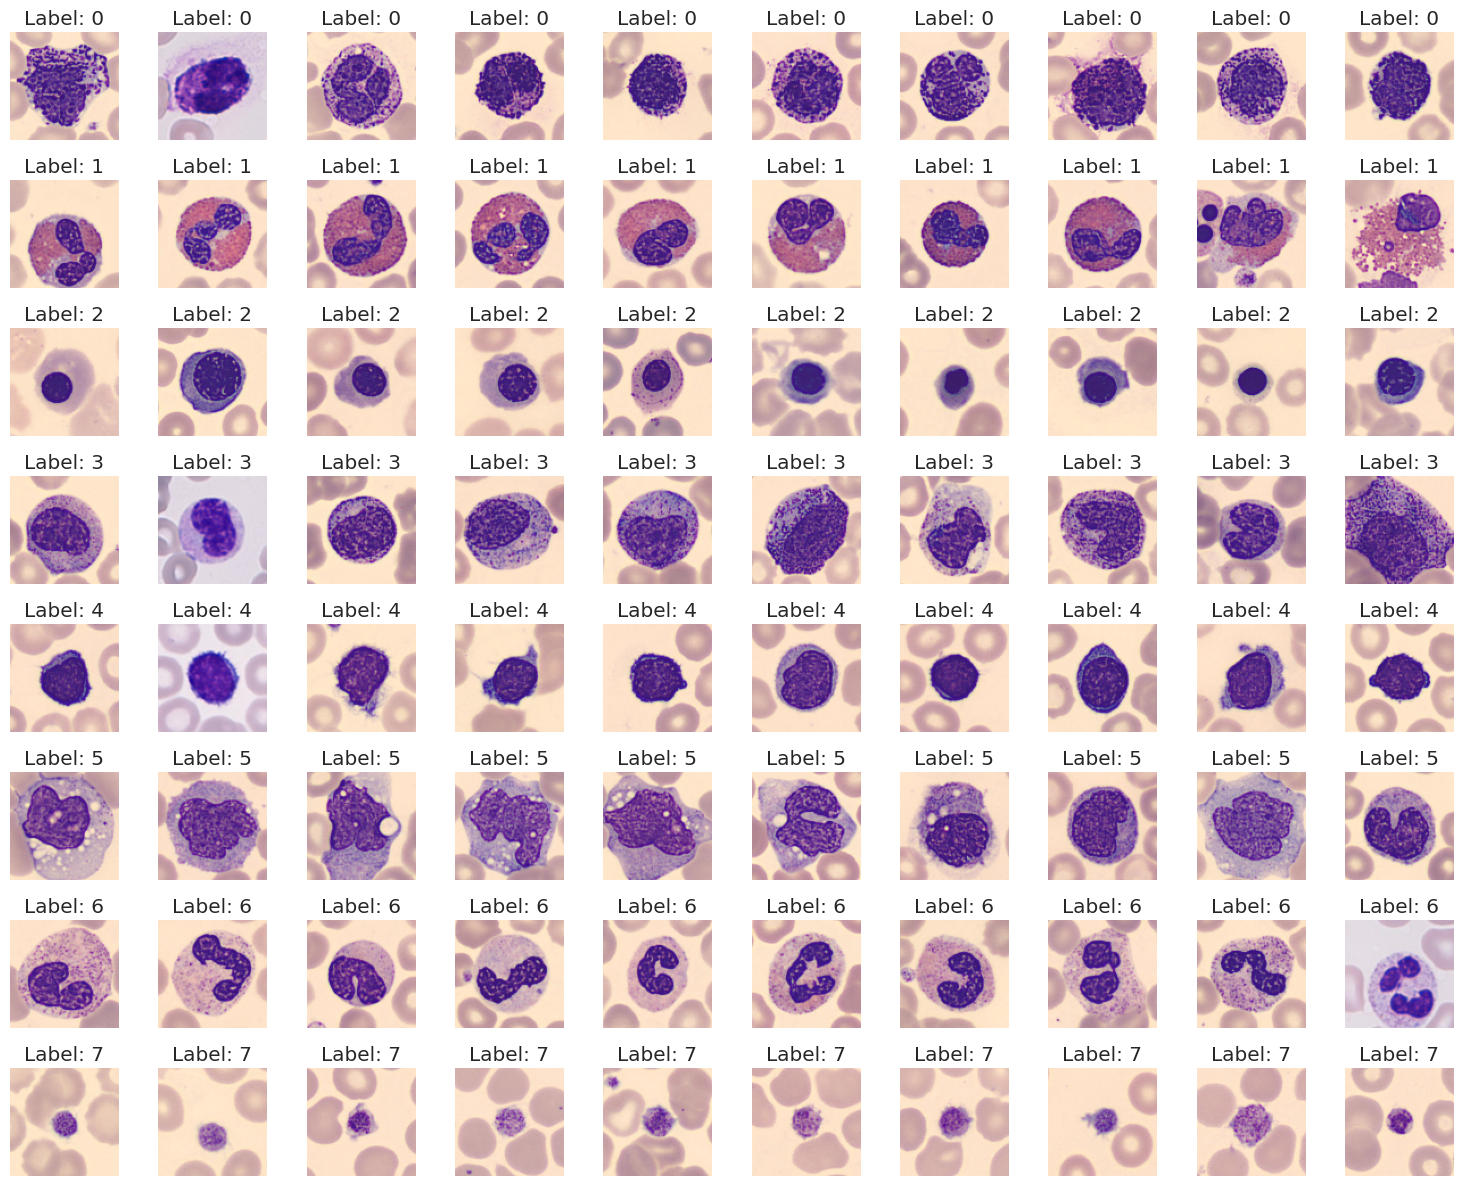

In [22]:
unique_labels = np.unique(labels)  # Get unique labels

# Calculate total number of subplots
num_subplots = len(unique_labels) * 10

# Calculate number of rows and columns for the grid
num_cols = 10
num_rows = num_subplots // num_cols
if num_subplots % num_cols != 0:
    num_rows += 1

# Create a single figure and axes with gridspec
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 1.5))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Counter for current subplot
subplot_idx = 0

for label in unique_labels:
    # Find indices of images with the current label
    indices = np.where(labels == label)[0]

    # Randomly select 10 indices
    selected_indices = random.sample(list(indices), 10)

    # Plot the selected images in the corresponding subplots
    for i, idx in enumerate(selected_indices):
        axes[subplot_idx].imshow(images[idx], cmap='gray')
        axes[subplot_idx].set_title(f'Label: {labels[idx][0]}')
        axes[subplot_idx].axis('off')
        subplot_idx += 1

# Hide any unused subplots
for i in range(subplot_idx, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

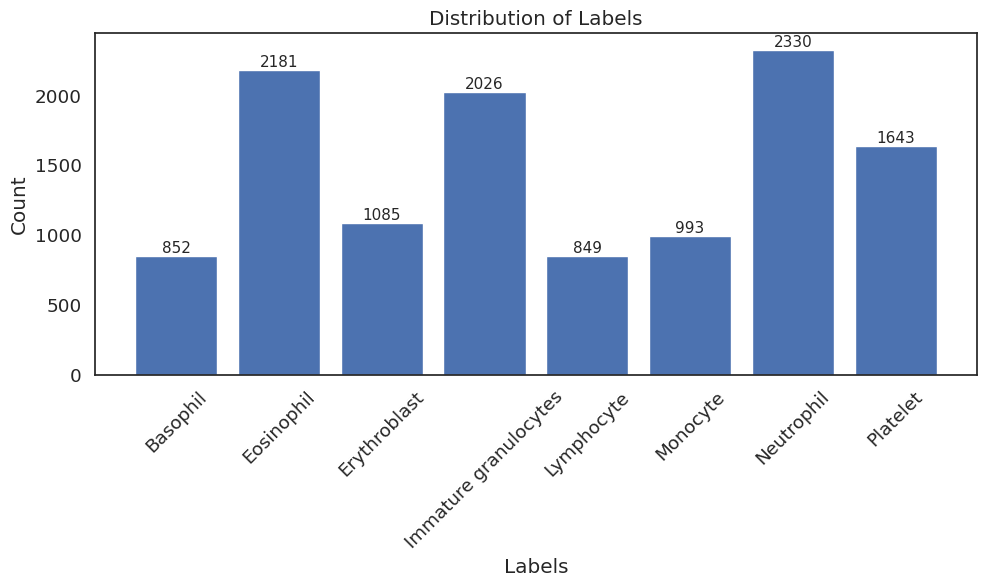

In [23]:
# Prepare label distribution
unique, counts = np.unique(labels, return_counts=True)
label_distribution = dict(zip(unique, counts))
label_names = [label_dict[label] for label in unique]

# Create figure with standard size
plt.figure(figsize=(10, 6))

# Create bar plot
plt.bar(range(len(label_distribution)), list(label_distribution.values()))

# Set x-ticks with label names
plt.xticks(range(len(label_distribution)), label_names, rotation=45)

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Add value labels on top of bars
for i, v in enumerate(label_distribution.values()):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display plot
plt.show()

## Data preprocessing

In [24]:
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming 'images' is your dataset of images and 'labels' are the corresponding labels
# Split the dataset into a combined training and validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images,
    labels,
    test_size=0.2,
    random_state=seed,
    stratify=labels
)

# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.2,
    random_state=seed,
    stratify=y_train_val
)

In [25]:
# One hot encoding
y_train = tfk.utils.to_categorical(y_train, num_classes=8)
y_test = tfk.utils.to_categorical(y_test, num_classes=8)
y_val = tfk.utils.to_categorical(y_val, num_classes=8)

In [26]:
# Print the shapes of the resulting sets before applying SMOTE
print('Training set shape:\t', X_train.shape, y_train.shape)
print('Validation set shape:\t', X_val.shape, y_val.shape)
print('Test set shape:\t\t', X_test.shape, y_test.shape)

Training set shape:	 (7653, 96, 96, 3) (7653, 8)
Validation set shape:	 (1914, 96, 96, 3) (1914, 8)
Test set shape:		 (2392, 96, 96, 3) (2392, 8)


# Data augmentation on the fly

In [ ]:
# Define a function to convert images to float32 and normalize them
def process_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.uint8)
    return image, label

randomLayers = tfk.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomZoom(0.1),
    ])

random_cutout = keras_cv.layers.RandomCutout(width_factor = 0.5, height_factor = 0.3, fill_value = 0.0)

randAug = keras_cv.layers.RandAugment(value_range=(0, 255), magnitude=0.3)

augmix = keras_cv.layers.AugMix(value_range=(0, 255), severity=0.3)

random_gridmask = keras_cv.layers.GridMask()

def augment_image(image, label):

    image = randomLayers(image)

    # Apply RandAugment to all images
    image = randAug(image)

    if random.random() > 0.5:
        image = random_cutout(image)

    if random.random() > 0.3:
        image = random_gridmask(image)

    return image, label

NameError: name 'tfk' is not defined

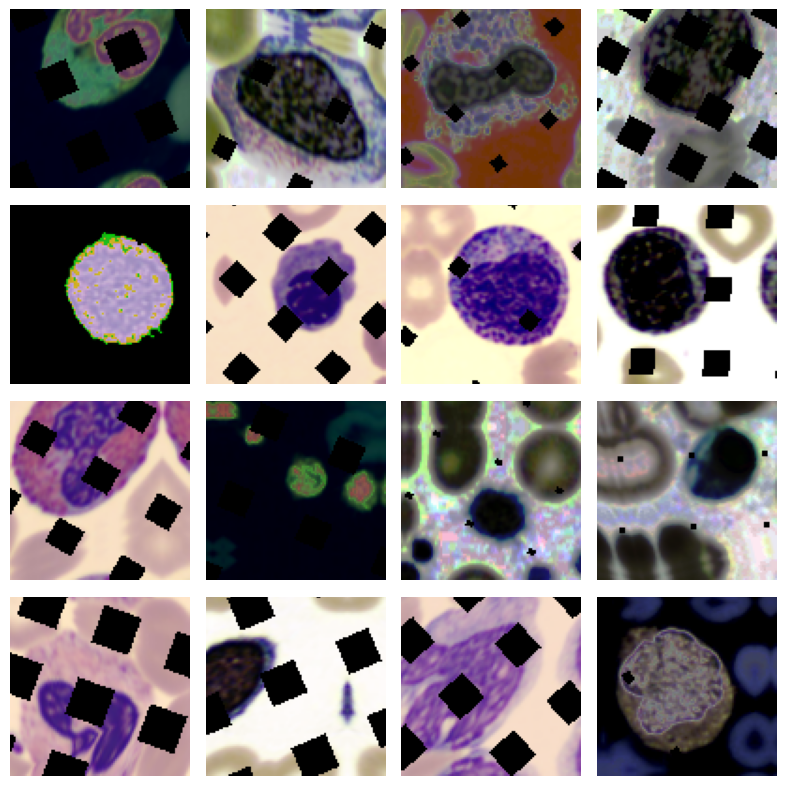

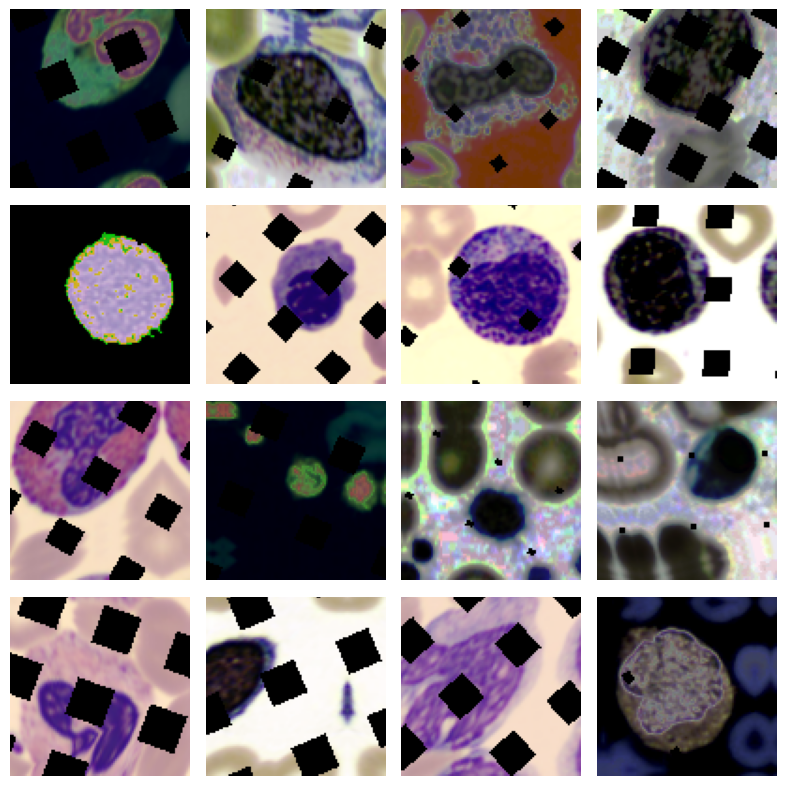

In [28]:
augmented_visualization_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(16)
    .take(1)
)

images = next(iter(augmented_visualization_ds.take(1)))[0]
keras_cv.visualization.plot_image_gallery(images, value_range=(0, 255))

In [29]:
augmented_visualization_ds

<_TakeDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float64, name=None))>

## Transfer Learning using EfficientNet

In [30]:
BATCH_SIZE = 32
INITIAL_LR = 1e-3
EPOCHS = 200

In [31]:
# Use class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 1.7520604395604396,
 1: 0.6852614613180515,
 2: 1.378422190201729,
 3: 0.737567463377024,
 4: 1.7617403314917126,
 5: 1.506496062992126,
 6: 0.6415995975855131,
 7: 0.9102045670789725}

In [32]:
# Initialise MobileNetV3Small model with pretrained weights, for transfer learning
effnet = tfk.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling='avg',
    classifier_activation="softmax",
    name="efficientnetv2-s",
)

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [33]:
# Freeze all layers in EfficientNetV2S to use it solely as a feature extractor
effnet.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=input_shape, name='input_layer')

# Pass inputs through the EfficientNetV2S feature extractor
x = effnet(inputs)

# Add batch normalization
x = tf.keras.layers.BatchNormalization(name='batch_norm_1')(x)

# Progressive dropout
x = tfkl.Dropout(0.3, name='dropout_1')(x)
x = tfkl.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005), name='dense_1')(x)
#x = tf.keras.layers.BatchNormalization(name='batch_norm_2')(x)

# Output layer
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='output')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=keras_cv.losses.FocalLoss(), optimizer=tfk.optimizers.Adam(INITIAL_LR), metrics=['accuracy'])

In [34]:
train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(process_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))

> ⚠️Warning: The following 2 cells regarding transfer learning training are not visibile because it was done before and just uploaded the weights. 

In [ ]:
# Train the model
history = tl_model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = val_ds,
    class_weight=class_weight_dict,
    callbacks=[
        tfk.callbacks.EarlyStopping(
            monitor='val_accuracy',
            mode='max',
            patience=20,
            restore_best_weights=True
        ),
        tfk.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6
        )
    ]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'BloodCells_EfficientNetV2S_eff_TF_RandAug'+str(final_val_accuracy)+'.keras'
tl_model.save(model_filename)

# Delete the model to free up resources
del tl_model

In [ ]:
# Create a figure with two vertically stacked subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 6), sharex=True)

# Plot training and validation loss
ax1.plot(history['loss'], label='Training loss', alpha=.8)
ax1.plot(history['val_loss'], label='Validation loss', alpha=.8)
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=.3)

# Plot training and validation accuracy
ax2.plot(history['accuracy'], label='Training accuracy', alpha=.8)
ax2.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

## Model evaluation

In [35]:
# Load the saved model
model = tfk.models.load_model('/kaggle/input/transfer/BloodCells_EfficientNetV2S_eff_TF_RandAug74.82.keras')

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-s            │ (None, 1280)          │ 20,331,360 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer_1          │ (None, 96, 96, 3)     │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ rescaling (Rescaling)  │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ stem_conv (Conv2D)     │ (None, 48, 48, 24)    │        648 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ stem_bn                │ (None, 48, 48, 24)    │         96 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ stem_activation        │ (None, 48, 48, 24)    │          0 │   -   │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1a_project_conv   │ (None, 48, 48, 24)    │      5,184 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1a_project_bn     │ (None, 48, 48, 24)    │         96 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 24)    │          0 │   -   │
│ block1a_project_activation  │                       │            │       │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1a_add (Add)      │ (None, 48, 48, 24)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1b_project_conv   │ (None, 48, 48, 24)    │      5,184 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1b_project_bn     │ (None, 48, 48, 24)    │         96 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 24)    │          0 │   -   │
│ block1b_project_activation  │                       │            │       │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1b_drop (Dropout) │ (None, 48, 48, 24)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1b_add (Add)      │ (None, 48, 48, 24)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block2a_expand_conv    │ (None, 24, 24, 96)    │     20,736 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block2a_expand_bn      │ (None, 24, 24, 96)    │        384 │   N   │
│ (BatchNormalization)        │                       │            │     

 Total params: 21,331,578 (81.37 MB)

 Trainable params: 332,552 (1.27 MB)

 Non-trainable params: 20,333,920 (77.57 MB)

 Optimizer params: 665,106 (2.54 MB)

I0000 00:00:1732213347.015968     640 service.cc:146] XLA service 0x7dde40028b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732213347.016022     640 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732213347.016025     640 service.cc:154]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732213353.887517     640 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Test Loss: 0.1110
Test Accuracy: 0.7475
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step
Test Accuracy (sklearn.metrics): 0.7475


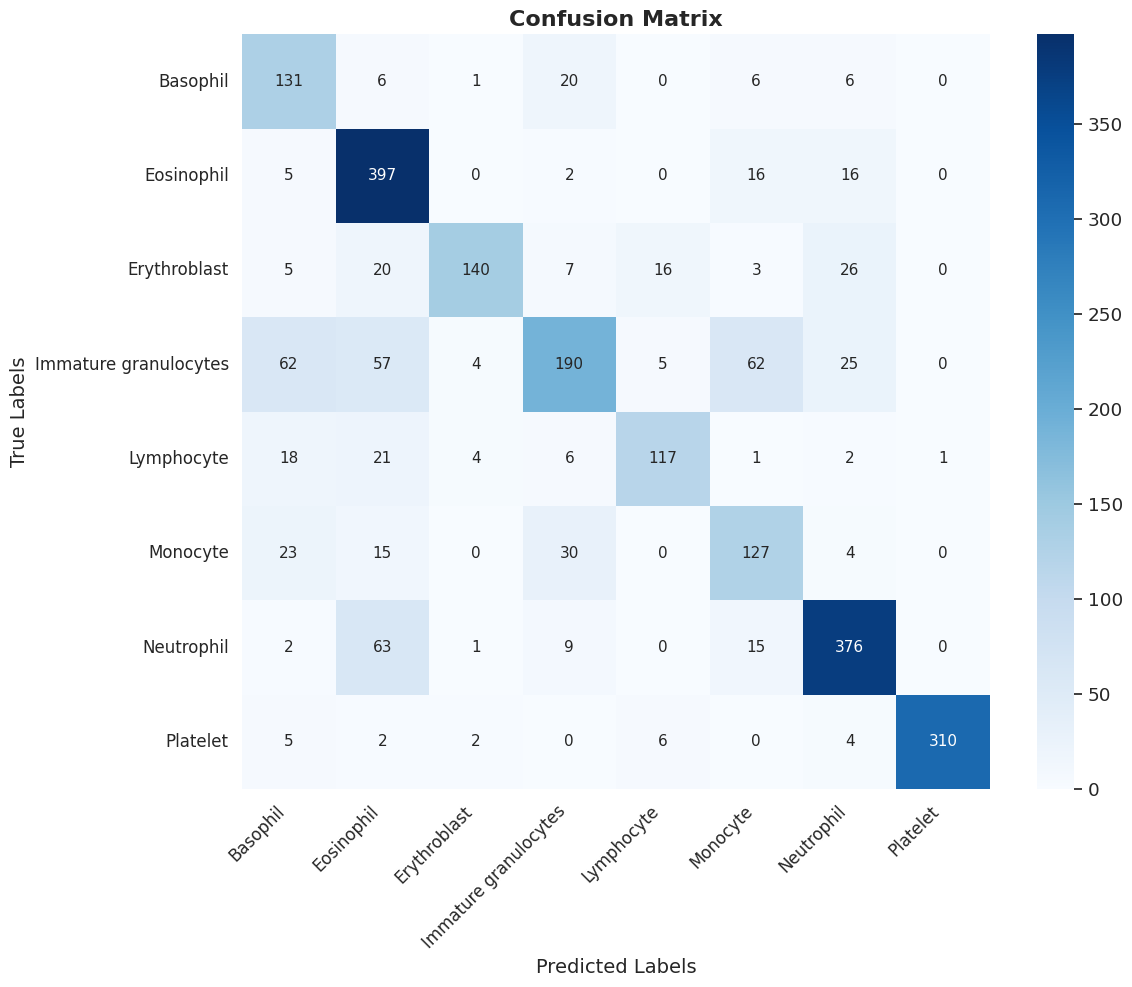

In [36]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Map label indices to names
label_names = [label_dict[i] for i in range(len(label_dict))]

# Calculate and print accuracy using sklearn.metrics
y_test_classes = np.argmax(y_test, axis=1)  # Convert y_test to class labels
accuracy_sklearn = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test Accuracy (sklearn.metrics): {accuracy_sklearn:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

# Fine tuning

In [37]:
BATCH_SIZE = 32
INITIAL_LR = 1e-4
EPOCHS = 200

In [38]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('/kaggle/input/transfer/BloodCells_EfficientNetV2S_eff_TF_RandAug74.82.keras')

In [39]:
# Set the EfficientNetV2S model layers as trainable
ft_model.get_layer('efficientnetv2-s').trainable = True

# Set all EfficientNetV2S layers as non-trainable
for layer in ft_model.get_layer('efficientnetv2-s').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-s').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

2 stem_conv Conv2D True
5 block1a_project_conv Conv2D True
9 block1b_project_conv Conv2D True
14 block2a_expand_conv Conv2D True
17 block2a_project_conv Conv2D True
19 block2b_expand_conv Conv2D True
22 block2b_project_conv Conv2D True
26 block2c_expand_conv Conv2D True
29 block2c_project_conv Conv2D True
33 block2d_expand_conv Conv2D True
36 block2d_project_conv Conv2D True
40 block3a_expand_conv Conv2D True
43 block3a_project_conv Conv2D True
45 block3b_expand_conv Conv2D True
48 block3b_project_conv Conv2D True
52 block3c_expand_conv Conv2D True
55 block3c_project_conv Conv2D True
59 block3d_expand_conv Conv2D True
62 block3d_project_conv Conv2D True
66 block4a_expand_conv Conv2D True
69 block4a_dwconv2 DepthwiseConv2D True
74 block4a_se_reduce Conv2D True
75 block4a_se_expand Conv2D True
77 block4a_project_conv Conv2D True
79 block4b_expand_conv Conv2D True
82 block4b_dwconv2 DepthwiseConv2D True
87 block4b_se_reduce Conv2D True
88 block4b_se_expand Conv2D True
90 block4b_project_c

In [40]:
# Set the number of layers to freeze
N = 124

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-s').layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-s').layers):
    print(i, layer.name, layer.trainable)

0 input_layer_1 False
1 rescaling False
2 stem_conv False
3 stem_bn False
4 stem_activation False
5 block1a_project_conv False
6 block1a_project_bn False
7 block1a_project_activation False
8 block1a_add False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block2d_expand_conv False
34 block2d_expand_bn False
35 block2d_expand_activation False
36 block2d_project_conv False
3

In [41]:
# Compile the model
ft_model.compile(loss=keras_cv.losses.FocalLoss(), optimizer=tfk.optimizers.Adam(INITIAL_LR), metrics=['accuracy'])

In [42]:
train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(process_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))

In [43]:
# Fine-tune the model
ft_history = ft_model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = val_ds,
    class_weight=class_weight_dict,
    callbacks=[
        tfk.callbacks.EarlyStopping(
            monitor='val_accuracy',
            mode='max',
            patience=20,
            restore_best_weights=True
        ),
        tfk.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-7
        )
    ]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'BloodCells_EfficientNetV2S_FT_TensorFlowAug_'+str(final_val_accuracy)+'.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

Epoch 1/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 150s 346ms/step - accuracy: 0.6434 - loss: 0.1243 - val_accuracy: 0.8380 - val_loss: 0.0796 - learning_rate: 1.0000e-04
Epoch 2/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 42s 169ms/step - accuracy: 0.8062 - loss: 0.0825 - val_accuracy: 0.9169 - val_loss: 0.0499 - learning_rate: 1.0000e-04
Epoch 3/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 42s 170ms/step - accuracy: 0.8361 - loss: 0.0735 - val_accuracy: 0.9117 - val_loss: 0.0505 - learning_rate: 1.0000e-04
Epoch 4/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 41s 167ms/step - accuracy: 0.8711 - loss: 0.0633 - val_accuracy: 0.9431 - val_loss: 0.0399 - learning_rate: 1.0000e-04
Epoch 5/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - accuracy: 0.8652 - loss: 0.0637 - val_accuracy: 0.9180 - val_loss: 0.0465 - learning_rate: 1.0000e-04
Epoch 6/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 42s 172ms/step - accuracy: 0.8975 - loss: 0.0523 - val_accuracy: 0.9556 - val_loss: 0.0324 - learning_rate: 1.0000e-04
Epoch 7/200
240/240 ━━━━━━━━━━━━━━━━━━━

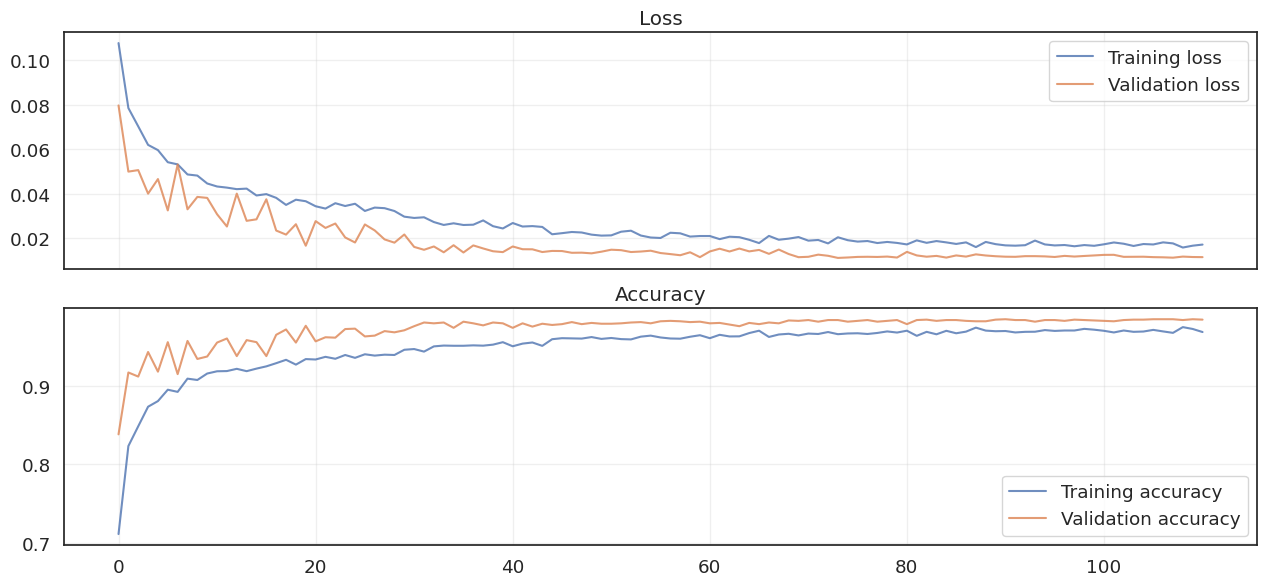

In [46]:
# Create a figure with two vertically stacked subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 6), sharex=True)

# Plot training and validation loss
ax1.plot(ft_history['loss'], label='Training loss', alpha=.8)
ax1.plot(ft_history['val_loss'], label='Validation loss', alpha=.8)
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=.3)

# Plot training and validation accuracy
ax2.plot(ft_history['accuracy'], label='Training accuracy', alpha=.8)
ax2.plot(ft_history['val_accuracy'], label='Validation accuracy', alpha=.8)
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

## Model evaluation

In [48]:
# Load the saved model
model = tfk.models.load_model('BloodCells_EfficientNetV2S_FT_TensorFlowAug_98.48.keras')

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-s            │ (None, 1280)          │ 20,331,360 │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer_1          │ (None, 96, 96, 3)     │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ rescaling (Rescaling)  │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ stem_conv (Conv2D)     │ (None, 48, 48, 24)    │        648 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ stem_bn                │ (None, 48, 48, 24)    │         96 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ stem_activation        │ (None, 48, 48, 24)    │          0 │   -   │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1a_project_conv   │ (None, 48, 48, 24)    │      5,184 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1a_project_bn     │ (None, 48, 48, 24)    │         96 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 24)    │          0 │   -   │
│ block1a_project_activation  │                       │            │       │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1a_add (Add)      │ (None, 48, 48, 24)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1b_project_conv   │ (None, 48, 48, 24)    │      5,184 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1b_project_bn     │ (None, 48, 48, 24)    │         96 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 24)    │          0 │   -   │
│ block1b_project_activation  │                       │            │       │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1b_drop (Dropout) │ (None, 48, 48, 24)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1b_add (Add)      │ (None, 48, 48, 24)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block2a_expand_conv    │ (None, 24, 24, 96)    │     20,736 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block2a_expand_bn      │ (None, 24, 24, 96)    │        384 │   N   │
│ (BatchNormalization)        │                       │            │     

 Total params: 58,445,834 (222.95 MB)

 Trainable params: 18,889,680 (72.06 MB)

 Non-trainable params: 1,776,792 (6.78 MB)

 Optimizer params: 37,779,362 (144.12 MB)

Test Loss: 0.0094
Test Accuracy: 0.9887
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step
Test Accuracy (sklearn.metrics): 0.9887


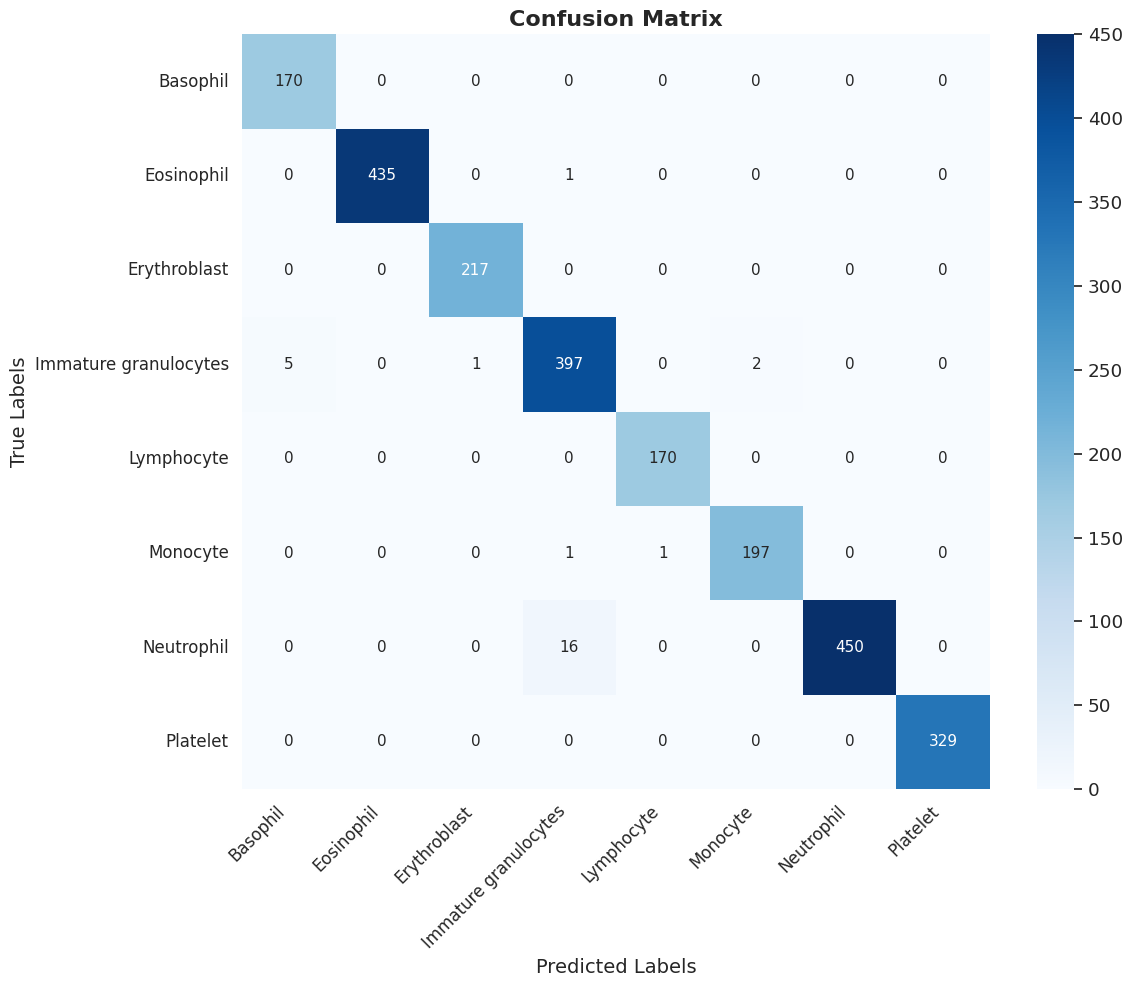

In [49]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Map label indices to names
label_names = [label_dict[i] for i in range(len(label_dict))]

# Calculate and print accuracy using sklearn.metrics
y_test_classes = np.argmax(y_test, axis=1)  # Convert y_test to class labels
accuracy_sklearn = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test Accuracy (sklearn.metrics): {accuracy_sklearn:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

In [50]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=[str(i) for i in unique_labels])
print(report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       170
           1       1.00      1.00      1.00       436
           2       1.00      1.00      1.00       217
           3       0.96      0.98      0.97       405
           4       0.99      1.00      1.00       170
           5       0.99      0.99      0.99       199
           6       1.00      0.97      0.98       466
           7       1.00      1.00      1.00       329

    accuracy                           0.99      2392
   macro avg       0.99      0.99      0.99      2392
weighted avg       0.99      0.99      0.99      2392



# Save model (TTA Testing)

In [51]:
%%writefile model.py
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras.preprocessing.image import img_to_array

class Model:

    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model("BloodCells_EfficientNetV2S_FT_TensorFlowAug_98.48.keras")


    def add_gaussian_noise(self, image, mean=0.0, stddev=0.05):
        noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev, dtype=image.dtype)
        return image + noise


    def tta_augmentations(self, image):
        """
        Apply domain-specific augmentations for TTA.
        Args:
            image: TensorFlow image tensor (H, W, C).
        Returns:
            List of augmented images.
        """
        augmentations = [
            image,  # Original
            tf.image.flip_left_right(image),  # Horizontal flip
            tf.image.flip_up_down(image),  # Vertical flip
            tf.image.rot90(image, k=1),  # Rotate 90 degrees
            tf.image.adjust_brightness(image, delta=0.1),  # Brightness adjustment
            tf.image.adjust_contrast(image, contrast_factor=1.1),  # Contrast adjustment
            tf.image.adjust_saturation(image, saturation_factor=1.2),  # Saturation adjustment
            self.add_gaussian_noise(image, mean=0.0, stddev=0.05),  # Gaussian noise
            # tf.image.central_crop(image, central_fraction=0.8),  # Central crop
        ]
        return augmentations


    def tta_predict_with_weights(self, image, weights, image_size):
        """
        Perform TTA with optimized augmentations.
        Args:
            model: Trained TensorFlow/Keras model.
            image: Original image (PIL or Tensor).
            augmentations: Augmentation function.
            image_size: Tuple (height, width) for resizing.
        Returns:
            Aggregated probabilities as the final prediction.
        """
        # remove first dimension if present
        if image.shape[0] == 1:
            image = image[0]

        # Preprocess the image
        if not isinstance(image, tf.Tensor):
            image = tf.convert_to_tensor(img_to_array(image))  # Convert to tensor if needed
        # image = tf.image.resize(image, image_size) / 255.0  # Resize and normalize

        # Generate augmented images
        augmented_images = self.tta_augmentations(image)
        augmented_images = tf.stack(augmented_images)

        # Batch predictions using the model
        predictions = self.neural_network.predict(np.array(augmented_images))
        predictions = tf.nn.softmax(predictions, axis=-1).numpy()
        return self.weighted_aggregation(predictions, weights)


    def weighted_aggregation(self, predictions, weights):
        """
        Perform weighted aggregation of predictions.
        Args:
            predictions: List of prediction arrays.
            weights: List of weights corresponding to each augmentation.
        Returns:
            Weighted average of predictions.
        """
        weighted_preds = [pred * weight for pred, weight in zip(predictions, weights)]
        return np.sum(weighted_preds, axis=0) / np.sum(weights)


    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        # Resize all images in X to 96x96x3 before prediction
        X = np.array([tf.image.resize_with_pad(img, 96, 96).numpy().astype(np.uint8) for img in X])

        final_preds = []
        for i in range(X.shape[0]):
            sample = np.expand_dims(X[i], axis=0)
            preds = self.tta_predict_with_weights(
                sample,
                weights = [1.2, 0.85, 0.9, 0.75, 1, 1, 1, 1.1],
                image_size=(96, 96)
            )
            preds = np.argmax(preds)
            final_preds.append(preds)
        return np.array(final_preds)

Writing model.py


In [52]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py BloodCells_EfficientNetV2S_FT_TensorFlowAug_98.48.keras


  adding: model.py (deflated 65%)
  adding: BloodCells_EfficientNetV2S_FT_TensorFlowAug_98.48.keras (deflated 8%)
